# Ames Housing Dataset -  Feature Selection

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Feature Selection (from domain knowledge and previous evidence)
* Feature Importance (assessed through XGBoost)
* Recursive Feature Elimination (assessed through Random Forest)
* Final Dataset Overview

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

---

###  Environment, Imports and Global Variables

In [1]:
# Interactive
%matplotlib notebook
# Static
# %matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore') 

# Working folder
WORKING_DIR = os.getcwd()
# Resources folder
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')
# Name of file
IN_LABEL = 'ames_housing_out_1.csv'
ORIG_LABEL = 'ames_housing_out_1_orig.csv'

In [2]:
# Utils Module

def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically and leaves last_label for last

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

In [3]:
# Module for correlation analysis

def display_corr_matrix(dataset: pd.core.frame.DataFrame, label: str, exclude = None):
    """
    Displays the correlation matrix and returns it
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param exclude: list of str of features to exclude
    : returns: correlation matrix
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    if exclude is not None:
        if type(exclude) == list:
            for i in exclude:
                if type(i)!= str:
                    raise Exception("exclude must be a list of string")
                if i not in dataset.columns:
                    raise Exception(i + " is not a valid column label")
        else:
            raise Exception("exclude must be a list")
            
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    """
    Returns a dictionary of the top correlated features with label, inside the dataset, for a certain threshold
    
    """
    
    m = corr[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    """
    Prints the correlated features for all the top correlated features with the target
    
    """
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

In [4]:
from sklearn.model_selection import train_test_split

# Module for train test split

def get_X_y(dataset, label, ignore=None):
    """
    Returns X and y and ignores labels in ignore
    :param dataset: a pd.DataFrame
    :param label: a str containing an existing target column label in the dataset
    :param ignore: a list of str containing an existing column label in the dataset to ignore
    :returns: tuple of pd.DataFrame
    """
    if ignore is not None:
        # Drop the labels 
        all_columns = list(dataset.columns)
        # Include only columns that are existing 
        to_drop = [i for i in all_columns if i in ignore] +[label]
        return dataset.drop(columns=to_drop), dataset[[label]]
    return dataset.drop(columns=[label]), dataset[[label]]

def get_train_test(X, y, size = 0.2, state = 33):
    """
    Returns X_train_[size], X_test, y_train_[size], y_test
    :param X: a pd.DataFrame without the target column
    :param y: a pd.DataFrame with one column, the target
    :param size: a float representing the fraction for the test size
    :param state: an integer representing the random state for the test
    :returns: 4 pd.DataFrame usually called "X_train_[size], X_test, y_train_[size], y_test"
    """
    return train_test_split(X, y, test_size=size, random_state = state)

def get_train_val_test(X, y, size_t=0.2, size_v=0.25, state_v = 42):
    """
    Returns X_train, X_valid, X_test, y_train, y_valid, y_test
    :param X: a pd.DataFrame without the target column
    :param y: a pd.DataFrame with one column, the target
    :param size_t: a float representing the fraction for the test size
    :param size_v: a float representing the fraction for the validation
    :param state_v: an integer representing the random state for the validation
    :returns: 6 pd.DataFrame usually called X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    X_train_s, X_test, y_train_s, y_test = get_train_test(X, y, size = size_t)
    X_train, X_valid, y_train, y_valid = get_train_test(X_train_s, y_train_s, size = size_v, state = state_v)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
from xgboost import XGBRegressor
from xgboost import plot_importance
# Module for feature importances

def plot_feature_importances(model, dataset):
    n_features = x.shape[1]
    plt.barh(range(n_features),model.feature_importances_,align="center")
    plt.yticks(np.arange(n_features),x)
    plt.xlabel("importance")
    plt.ylabel("features")
    plt.show
    pass

def plot_xgb_importance(dataset, target, ignore = None,  subset= None):
    # Data
    X, y = get_X_y(dataset=dataset, 
                   label=target, ignore=ignore)
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_val_test(X, y, size_t=0.2, size_v=0.25, state_v = 42)
    # Model
    model = XGBRegressor(n_estimators = 10,
                         max_depth = 12,
                         max_leaves = 12,
                         learning_rate = 0.5, 
                         importance_type = 'weight',
                         sampling_method = 'gradient_based', 
                         random_state = 292359329)
    # Fit
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],verbose=False)
    # Importance
    plot_importance(model, max_num_features = 30)
    plt.show()
    return list(model.feature_names_in_)

In [6]:
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Module for RFECV

def rfe_estim(dataset, target, estimator, cv, ignore=None):
    X, y = get_X_y(dataset=dataset, label=target, ignore=ignore)
    selector = RFECV(estimator=estimator, 
                     step=1, 
                     min_features_to_select=30, 
                     cv= cv, 
                     scoring='neg_mean_squared_error', 
                     n_jobs=-1, importance_getter='auto')
    selector = selector.fit(X, y)
    
    print('The optimal number of features is {}'.format(selector.n_features_))
    features = [f for f,s in zip(X.columns, selector.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    return features

In [7]:
df = pd.read_csv(os.path.join(RESOURCES_DIR, IN_LABEL))
df_orig = pd.read_csv(os.path.join(RESOURCES_DIR, ORIG_LABEL))

df.drop(columns='Unnamed: 0', inplace=True)
df_orig.drop(columns='Unnamed: 0', inplace=True)

df = sort_alphabetically(df, 'Sale_Price')
df_orig = sort_alphabetically(df_orig, 'Sale_Price')

---

## Removing obvious misleading and irrelevant attributes

From our previous analysis we have some level of insight about what features we want to consider.
* We are obviously going to remove the `Latitude` and `Logitude` as these feature are most likely leading to overfitting, but they are still needed for the GNN, so we are going to ignore them for now.
* Other features are not really useful from what we learnt and we ar going to show this with feature importance
* Others were the result of the combinations or transformations of initial features

We are going to take into account these information to avoid redundancy in the dataset

---

## Feature Importance

Impurting feature importance through Correlation, Xgboost Importance Estimation, and RFE

### Correlation

<IPython.core.display.Javascript object>


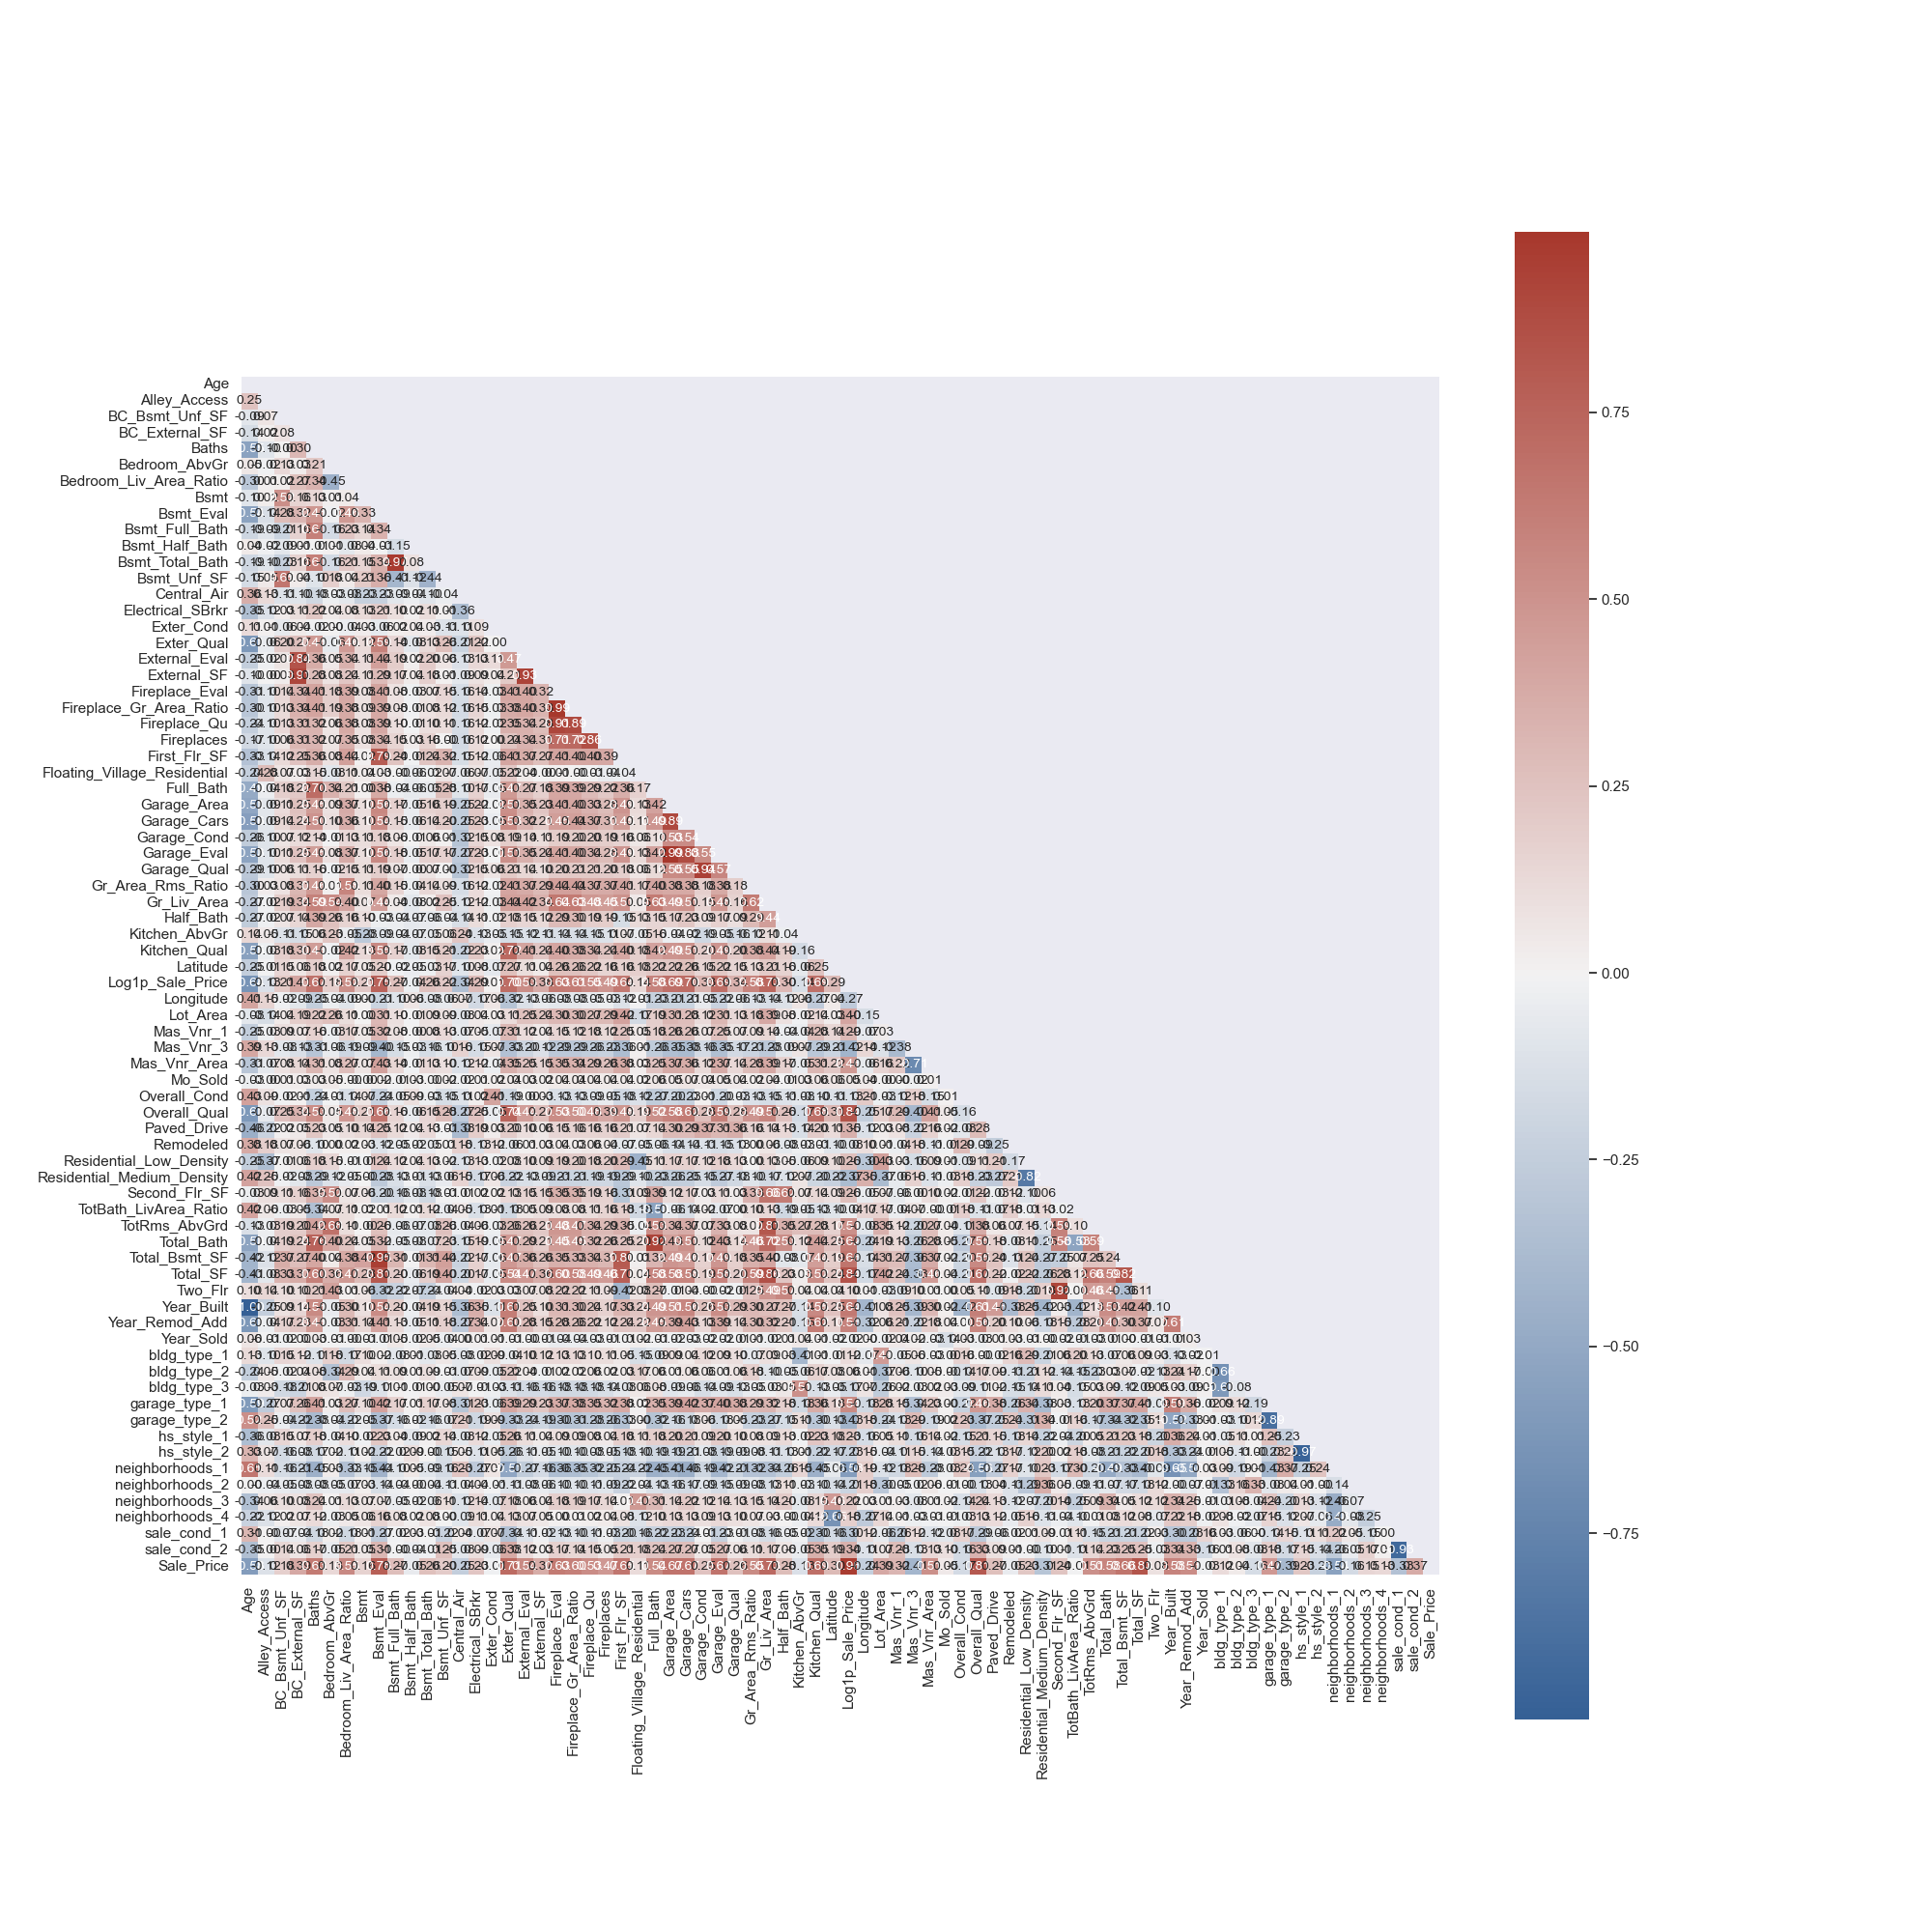

In [8]:
corr = display_corr_matrix(sort_alphabetically(df, 'Sale_Price'), label='Sale_Price')

In [9]:
top_corr_dict = top_correlated_features(corr, 'Sale_Price', 0.40)
top_corr_dict

{'Total_SF': 0.831830413595234,
 'Overall_Qual': 0.8117625341990397,
 'Bsmt_Eval': 0.77765820613712,
 'Gr_Liv_Area': 0.7257798387940613,
 'Exter_Qual': 0.7148047608934632,
 'Kitchen_Qual': 0.6887093084037993,
 'Garage_Area': 0.6681346194103982,
 'Garage_Eval': 0.6680762754078051,
 'Garage_Cars': 0.6669296938018384,
 'Total_Bsmt_SF': 0.6645126924806144,
 'First_Flr_SF': 0.6494304150165117,
 'Baths': 0.6330306213900416,
 'Fireplace_Eval': 0.6277197319771475,
 'Fireplace_Gr_Area_Ratio': 0.6025121788984277,
 'Year_Built': 0.5834995693412479,
 'Total_Bath': 0.5751719494861582,
 'Bedroom_Liv_Area_Ratio': 0.5496091971693476,
 'Gr_Area_Rms_Ratio': 0.5455744720388533,
 'External_Eval': 0.5412391075150473,
 'Full_Bath': 0.5405522072683838,
 'Fireplace_Qu': 0.5341356572440731,
 'Year_Remod_Add': 0.5338731340714287,
 'Mas_Vnr_Area': 0.5143581269042917,
 'TotRms_AbvGrd': 0.5102272169941826,
 'garage_type_1': 0.47413465459280585,
 'Fireplaces': 0.4706721579135879,
 'Mas_Vnr_3': -0.41422570644457873,

It is easy to understand the correlation between these variables and the target feature, as almost each one of the datasets shows almost always the same estimated correlations. However, as the result might be biased by the presence of multiple variables, we want to try another approach.

### XGBoost Regressor - Feature Importance

We can use the XGboost regressor to infer importance of features, as these kinds of trees present a way to infer it based on some metrics such as coverage or weight. 

<IPython.core.display.Javascript object>


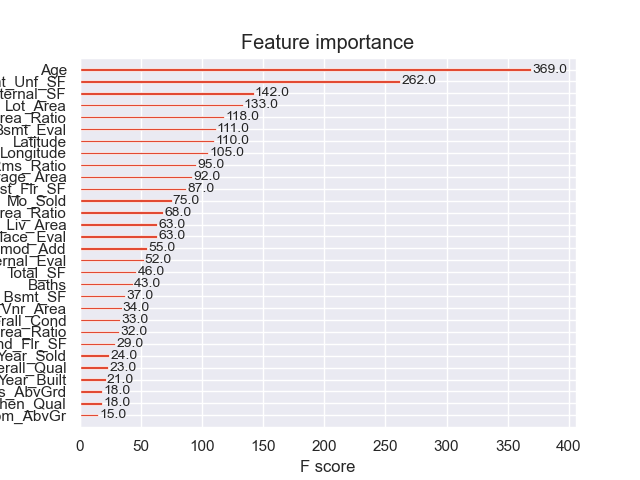

['Age',
 'Alley_Access',
 'BC_Bsmt_Unf_SF',
 'BC_External_SF',
 'Baths',
 'Bedroom_AbvGr',
 'Bedroom_Liv_Area_Ratio',
 'Bsmt',
 'Bsmt_Eval',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Total_Bath',
 'Bsmt_Unf_SF',
 'Central_Air',
 'Electrical_SBrkr',
 'Exter_Cond',
 'Exter_Qual',
 'External_Eval',
 'External_SF',
 'Fireplace_Eval',
 'Fireplace_Gr_Area_Ratio',
 'Fireplace_Qu',
 'Fireplaces',
 'First_Flr_SF',
 'Floating_Village_Residential',
 'Full_Bath',
 'Garage_Area',
 'Garage_Cars',
 'Garage_Cond',
 'Garage_Eval',
 'Garage_Qual',
 'Gr_Area_Rms_Ratio',
 'Gr_Liv_Area',
 'Half_Bath',
 'Kitchen_AbvGr',
 'Kitchen_Qual',
 'Latitude',
 'Longitude',
 'Lot_Area',
 'Mas_Vnr_1',
 'Mas_Vnr_3',
 'Mas_Vnr_Area',
 'Mo_Sold',
 'Overall_Cond',
 'Overall_Qual',
 'Paved_Drive',
 'Remodeled',
 'Residential_Low_Density',
 'Residential_Medium_Density',
 'Second_Flr_SF',
 'TotBath_LivArea_Ratio',
 'TotRms_AbvGrd',
 'Total_Bath',
 'Total_Bsmt_SF',
 'Total_SF',
 'Two_Flr',
 'Year_Built',
 'Year_Remod_Add',


In [10]:
plot_xgb_importance(dataset = df, target = 'Sale_Price', ignore = 'Log1p_Sale_Price')

<IPython.core.display.Javascript object>


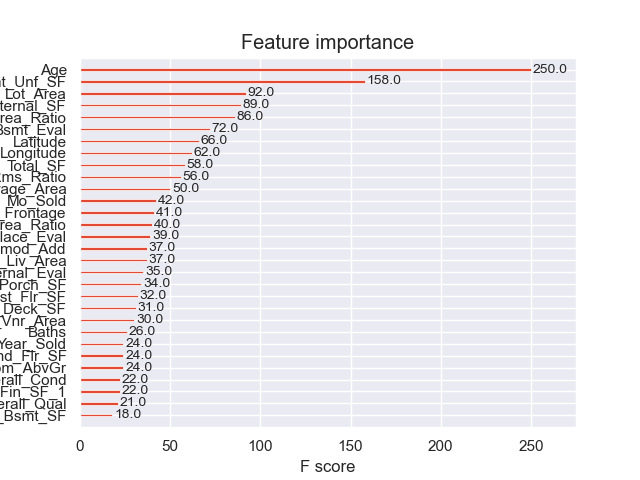

['A_agr',
 'Age',
 'AllPub',
 'Alley_Access',
 'Artery',
 'AsbShng',
 'AsphShn',
 'BC_Bsmt_Unf_SF',
 'BC_External_SF',
 'Baths',
 'Bedroom_AbvGr',
 'Bedroom_Liv_Area_Ratio',
 'Brk Cmn',
 'BrkComm',
 'BrkFace',
 'BrkTil',
 'Bsmt',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'BsmtFin_Type_1',
 'BsmtFin_Type_2',
 'Bsmt_Cond',
 'Bsmt_Eval',
 'Bsmt_Exposure',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Qual',
 'Bsmt_Total_Bath',
 'Bsmt_Unf_SF',
 'CBlock',
 'COD',
 'CWD',
 'C_all',
 'CemntBd',
 'Central_Air',
 'ClyTile',
 'CmentBd',
 'CompShg',
 'Con',
 'ConLD',
 'ConLI',
 'ConLw',
 'Corner',
 'CulDSac',
 'Duplex_All_Styles_and_Ages',
 'Electrical_SBrkr',
 'Elev',
 'Enclosed_Porch',
 'Exter_Cond',
 'Exter_Qual',
 'External_Eval',
 'External_SF',
 'FR2',
 'FR3',
 'Feedr',
 'Fence',
 'Fireplace_Eval',
 'Fireplace_Gr_Area_Ratio',
 'Fireplace_Qu',
 'Fireplaces',
 'First_Flr_SF',
 'Flat',
 'Floating_Village_Residential',
 'Floor',
 'Full_Bath',
 'Functional',
 'Gable',
 'Gambrel',
 'Gar2',
 'Garage_Area'

In [11]:
plot_xgb_importance(dataset = df_orig, target = 'Sale_Price', ignore = 'Log1p_Sale_Price')

As we predicted, most of the features we showed during the EDA, are relevant!

## Recursive Feature Elimination

Since we have seen that we really want to use the sale price, we prefer to ignore the logarithm transformation to avoid the variance it might cause

In [12]:
xgb = XGBRegressor(n_estimators = 8,
                             max_depth = 7,
                             max_leaves = 11,
                             learning_rate = 0.5, 
                             importance_type = 'weight', 
                             random_state = 292359329)
cv_rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)

In [13]:
f1 = rfe_estim(df, target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 46
The selected features are:
['Age', 'BC_Bsmt_Unf_SF', 'BC_External_SF', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt_Eval', 'Bsmt_Full_Bath', 'Bsmt_Total_Bath', 'Central_Air', 'Exter_Qual', 'External_Eval', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Garage_Area', 'Garage_Cars', 'Garage_Eval', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Kitchen_Qual', 'Latitude', 'Longitude', 'Lot_Area', 'Mas_Vnr_Area', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive', 'Residential_Medium_Density', 'Second_Flr_SF', 'TotBath_LivArea_Ratio', 'TotRms_AbvGrd', 'Total_Bsmt_SF', 'Total_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'bldg_type_1', 'garage_type_1', 'hs_style_1', 'neighborhoods_1', 'neighborhoods_3', 'sale_cond_1']


In [14]:
f2 = rfe_estim(df_orig, target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 81
The selected features are:
['Age', 'Alley_Access', 'AsbShng', 'BC_Bsmt_Unf_SF', 'BC_External_SF', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Brk Cmn', 'BrkFace', 'BrkTil', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'Bsmt_Cond', 'Bsmt_Eval', 'Bsmt_Exposure', 'Bsmt_Qual', 'COD', 'C_all', 'Central_Air', 'CompShg', 'ConLw', 'Enclosed_Porch', 'Exter_Cond', 'External_Eval', 'FR2', 'Fence', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Functional', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Eval', 'Garage_Finish', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Heating_QC', 'Kitchen_Qual', 'Land_Contour', 'Latitude', 'Longitude', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_Area', 'Mo_Sold', 'One_Story_1945_and_Older', 'Open_Porch_SF', 'Oth', 'Overall_Cond', 'Overall_Qual', 'PConc', 'Remodeled', 'Residential_Medium_Density', 'Screen_Porch', 'Second_Flr_SF', 'Shed', 'TotBath_LivArea_Ratio', 

In [15]:
# The features selected by the xgb combined:
list(set(f1) | set(f2))

['Oth',
 'Functional',
 'Open_Porch_SF',
 'Alley_Access',
 'neighborhoods_1',
 'BC_Bsmt_Unf_SF',
 'Bsmt_Eval',
 'Bsmt_Cond',
 'External_Eval',
 'Mas_Vnr_Area',
 'Lot_Area',
 'Baths',
 'Fireplaces',
 'Garage_Cars',
 'Total_SF',
 'Fireplace_Gr_Area_Ratio',
 'Second_Flr_SF',
 'Exter_Qual',
 'sale_cond_3',
 'Garage_Eval',
 'Paved_Drive',
 'sale_cond_1',
 'Central_Air',
 'Lot_Frontage',
 'Bsmt_Qual',
 'Two_Family_conversion_All_Styles_and_Ages',
 'AsbShng',
 'Half_Bath',
 'Remodeled',
 'BrkFace',
 'Year_Remod_Add',
 'First_Flr_SF',
 'Total_Bath',
 'Gr_Liv_Area',
 'One_Story_1945_and_Older',
 'Brk Cmn',
 'BsmtFin_SF_2',
 'Heating_QC',
 'WD ',
 'Fireplace_Eval',
 'Latitude',
 'Year_Sold',
 'ConLw',
 'FR2',
 'Screen_Porch',
 'Garage_Area',
 'bldg_type_1',
 'Mo_Sold',
 'TotRms_AbvGrd',
 'BsmtFin_Type_1',
 'Overall_Cond',
 'BC_External_SF',
 'Longitude',
 'Exter_Cond',
 'Shed',
 'CompShg',
 'Bsmt_Full_Bath',
 'Residential_Medium_Density',
 'Age',
 'hs_style_1',
 'Year_Built',
 'BsmtFin_SF_1',
 '

As we can see the RFE on the original datasets almost always leads to a higher number of features. Now, for the sake of choosing a good subset of features, we can try with a naive random forest approach:

In [16]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=7,
                           bootstrap=True, 
                           n_jobs=-1, 
                           random_state=2546243645, 
                           verbose=0)

In [17]:
f3 = rfe_estim(df, target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 53
The selected features are:
['Age', 'BC_Bsmt_Unf_SF', 'BC_External_SF', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt_Eval', 'Bsmt_Full_Bath', 'Bsmt_Total_Bath', 'Bsmt_Unf_SF', 'Central_Air', 'Exter_Cond', 'Exter_Qual', 'External_Eval', 'External_SF', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplaces', 'First_Flr_SF', 'Garage_Area', 'Garage_Cars', 'Garage_Eval', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_Qual', 'Latitude', 'Longitude', 'Lot_Area', 'Mas_Vnr_1', 'Mas_Vnr_Area', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive', 'Residential_Low_Density', 'Residential_Medium_Density', 'Second_Flr_SF', 'TotBath_LivArea_Ratio', 'TotRms_AbvGrd', 'Total_Bath', 'Total_Bsmt_SF', 'Total_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'bldg_type_1', 'bldg_type_3', 'garage_type_1', 'neighborhoods_1', 'neighborhoods_3', 'neighborhoods_4', 'sale_cond_1']


In [18]:
f4 = rfe_estim(df_orig, target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 134
The selected features are:
['Age', 'AllPub', 'Alley_Access', 'Artery', 'AsbShng', 'AsphShn', 'BC_Bsmt_Unf_SF', 'BC_External_SF', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Brk Cmn', 'BrkComm', 'BrkFace', 'BrkTil', 'Bsmt', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Cond', 'Bsmt_Eval', 'Bsmt_Exposure', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Qual', 'Bsmt_Total_Bath', 'Bsmt_Unf_SF', 'CBlock', 'COD', 'CWD', 'C_all', 'CemntBd', 'Central_Air', 'CompShg', 'ConLw', 'Corner', 'Duplex_All_Styles_and_Ages', 'Enclosed_Porch', 'Exter_Cond', 'Exter_Qual', 'External_Eval', 'External_SF', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Floating_Village_Residential', 'Floor', 'Full_Bath', 'Functional', 'Gable', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Eval', 'Garage_Finish', 'Garage_Qual', 'GasW', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'HdBoard', 'Heating_QC

In [19]:
list(set(f3) & set(f4))

['neighborhoods_4',
 'Mo_Sold',
 'TotRms_AbvGrd',
 'Overall_Cond',
 'BC_Bsmt_Unf_SF',
 'Bsmt_Eval',
 'neighborhoods_1',
 'External_Eval',
 'Mas_Vnr_Area',
 'BC_External_SF',
 'Lot_Area',
 'Baths',
 'Longitude',
 'Fireplaces',
 'Exter_Cond',
 'External_SF',
 'Garage_Cars',
 'Total_SF',
 'Bsmt_Full_Bath',
 'Fireplace_Gr_Area_Ratio',
 'Residential_Medium_Density',
 'Age',
 'Second_Flr_SF',
 'Exter_Qual',
 'Garage_Eval',
 'Paved_Drive',
 'Year_Built',
 'Central_Air',
 'Mas_Vnr_1',
 'sale_cond_1',
 'Bsmt_Unf_SF',
 'neighborhoods_3',
 'Half_Bath',
 'Total_Bsmt_SF',
 'Bedroom_AbvGr',
 'Kitchen_Qual',
 'Overall_Qual',
 'TotBath_LivArea_Ratio',
 'Year_Remod_Add',
 'First_Flr_SF',
 'Total_Bath',
 'Gr_Liv_Area',
 'Residential_Low_Density',
 'Bedroom_Liv_Area_Ratio',
 'Fireplace_Eval',
 'Bsmt_Total_Bath',
 'Latitude',
 'Year_Sold',
 'garage_type_1',
 'Gr_Area_Rms_Ratio',
 'Garage_Area',
 'bldg_type_1']

As we predicted the OHE has affected the base estimator.

In [20]:
list((set(f3) & set(f4)) & (set(f3) & set(f4)))

['neighborhoods_4',
 'Mo_Sold',
 'TotRms_AbvGrd',
 'Overall_Cond',
 'BC_Bsmt_Unf_SF',
 'Bsmt_Eval',
 'neighborhoods_1',
 'External_Eval',
 'Mas_Vnr_Area',
 'BC_External_SF',
 'Lot_Area',
 'Baths',
 'Longitude',
 'Fireplaces',
 'Exter_Cond',
 'External_SF',
 'Garage_Cars',
 'Total_SF',
 'Bsmt_Full_Bath',
 'Fireplace_Gr_Area_Ratio',
 'Residential_Medium_Density',
 'Age',
 'Second_Flr_SF',
 'Exter_Qual',
 'Garage_Eval',
 'Paved_Drive',
 'Year_Built',
 'Central_Air',
 'Mas_Vnr_1',
 'sale_cond_1',
 'Bsmt_Unf_SF',
 'neighborhoods_3',
 'Half_Bath',
 'Total_Bsmt_SF',
 'Bedroom_AbvGr',
 'Kitchen_Qual',
 'Overall_Qual',
 'TotBath_LivArea_Ratio',
 'Year_Remod_Add',
 'First_Flr_SF',
 'Total_Bath',
 'Gr_Liv_Area',
 'Residential_Low_Density',
 'Bedroom_Liv_Area_Ratio',
 'Fireplace_Eval',
 'Bsmt_Total_Bath',
 'Latitude',
 'Year_Sold',
 'garage_type_1',
 'Gr_Area_Rms_Ratio',
 'Garage_Area',
 'bldg_type_1']

---

## Feature Selection

Now we shall find a compromise between all the features in order to save just the important ones for the boosted random forest.
For what concerns the GCN, we are going to add some more features since some of them are just the encoding of previous categorical features.

From all the analysis done until now, I personally believe this is the best subset to use, but we need to avoid redundancy.

In [21]:
subset_1 =['BC_Bsmt_Unf_SF',
 'Bedroom_AbvGr',
 'Bsmt_Full_Bath',
 'Bsmt_Unf_SF',
 'Central_Air',
 'External_Eval',
 'Fireplace_Gr_Area_Ratio',
 'Fireplace_Qu',
 'Garage_Area','Garage_Qual','Garage_Cars',
 'Gr_Liv_Area',
 'Kitchen_Qual',
 'Latitude',
 'Longitude',
 'Lot_Area',
 'Mas_Vnr_1','Mas_Vnr_Area',
 'Mo_Sold',
 'Overall_Qual',
 'Paved_Drive',
 'Residential_Low_Density', 'Residential_Medium_Density',
 'TotRms_AbvGrd',
 'Total_Bath',
 'Total_Bsmt_SF',
 'Year_Built',
 'Year_Remod_Add',
 'Year_Sold',
 'bldg_type_1',
 'bldg_type_3',
 'garage_type_1',
 'hs_style_1',
 'neighborhoods_1',
 'neighborhoods_2',
 'neighborhoods_3',
 'neighborhoods_4',
 'sale_cond_1',
 'Sale_Price']


subset_2 = ['Age',
 'BC_Bsmt_Unf_SF',
 'BC_External_SF',
 'Baths',
 'Bedroom_Liv_Area_Ratio',
 'Bsmt_Eval',
 'Bsmt_Unf_SF',
 'Central_Air',
 'Exter_Qual',
 'Fireplace_Eval',
 'Fireplaces',
 'Garage_Eval',
 'Gr_Area_Rms_Ratio',
 'Kitchen_Qual',
 'Latitude',
 'Longitude',
 'Lot_Area',
 'Mas_Vnr_1',
 'Mas_Vnr_Area',
 'Mo_Sold',
 'Overall_Qual',
 'Paved_Drive',
 'Residential_Low_Density',
 'Residential_Medium_Density',
 'TotBath_LivArea_Ratio',
 'TotRms_AbvGrd',
 'Total_SF',
 'Year_Sold',
 'bldg_type_1',
 'bldg_type_3',
 'garage_type_1',
 'hs_style_1',
 'neighborhoods_1',
 'neighborhoods_3',
 'neighborhoods_4',
 'sale_cond_1', 'Sale_Price']

I tried to make the two subsets, use different combinations of the same features.

### One last time - Correlation

<IPython.core.display.Javascript object>


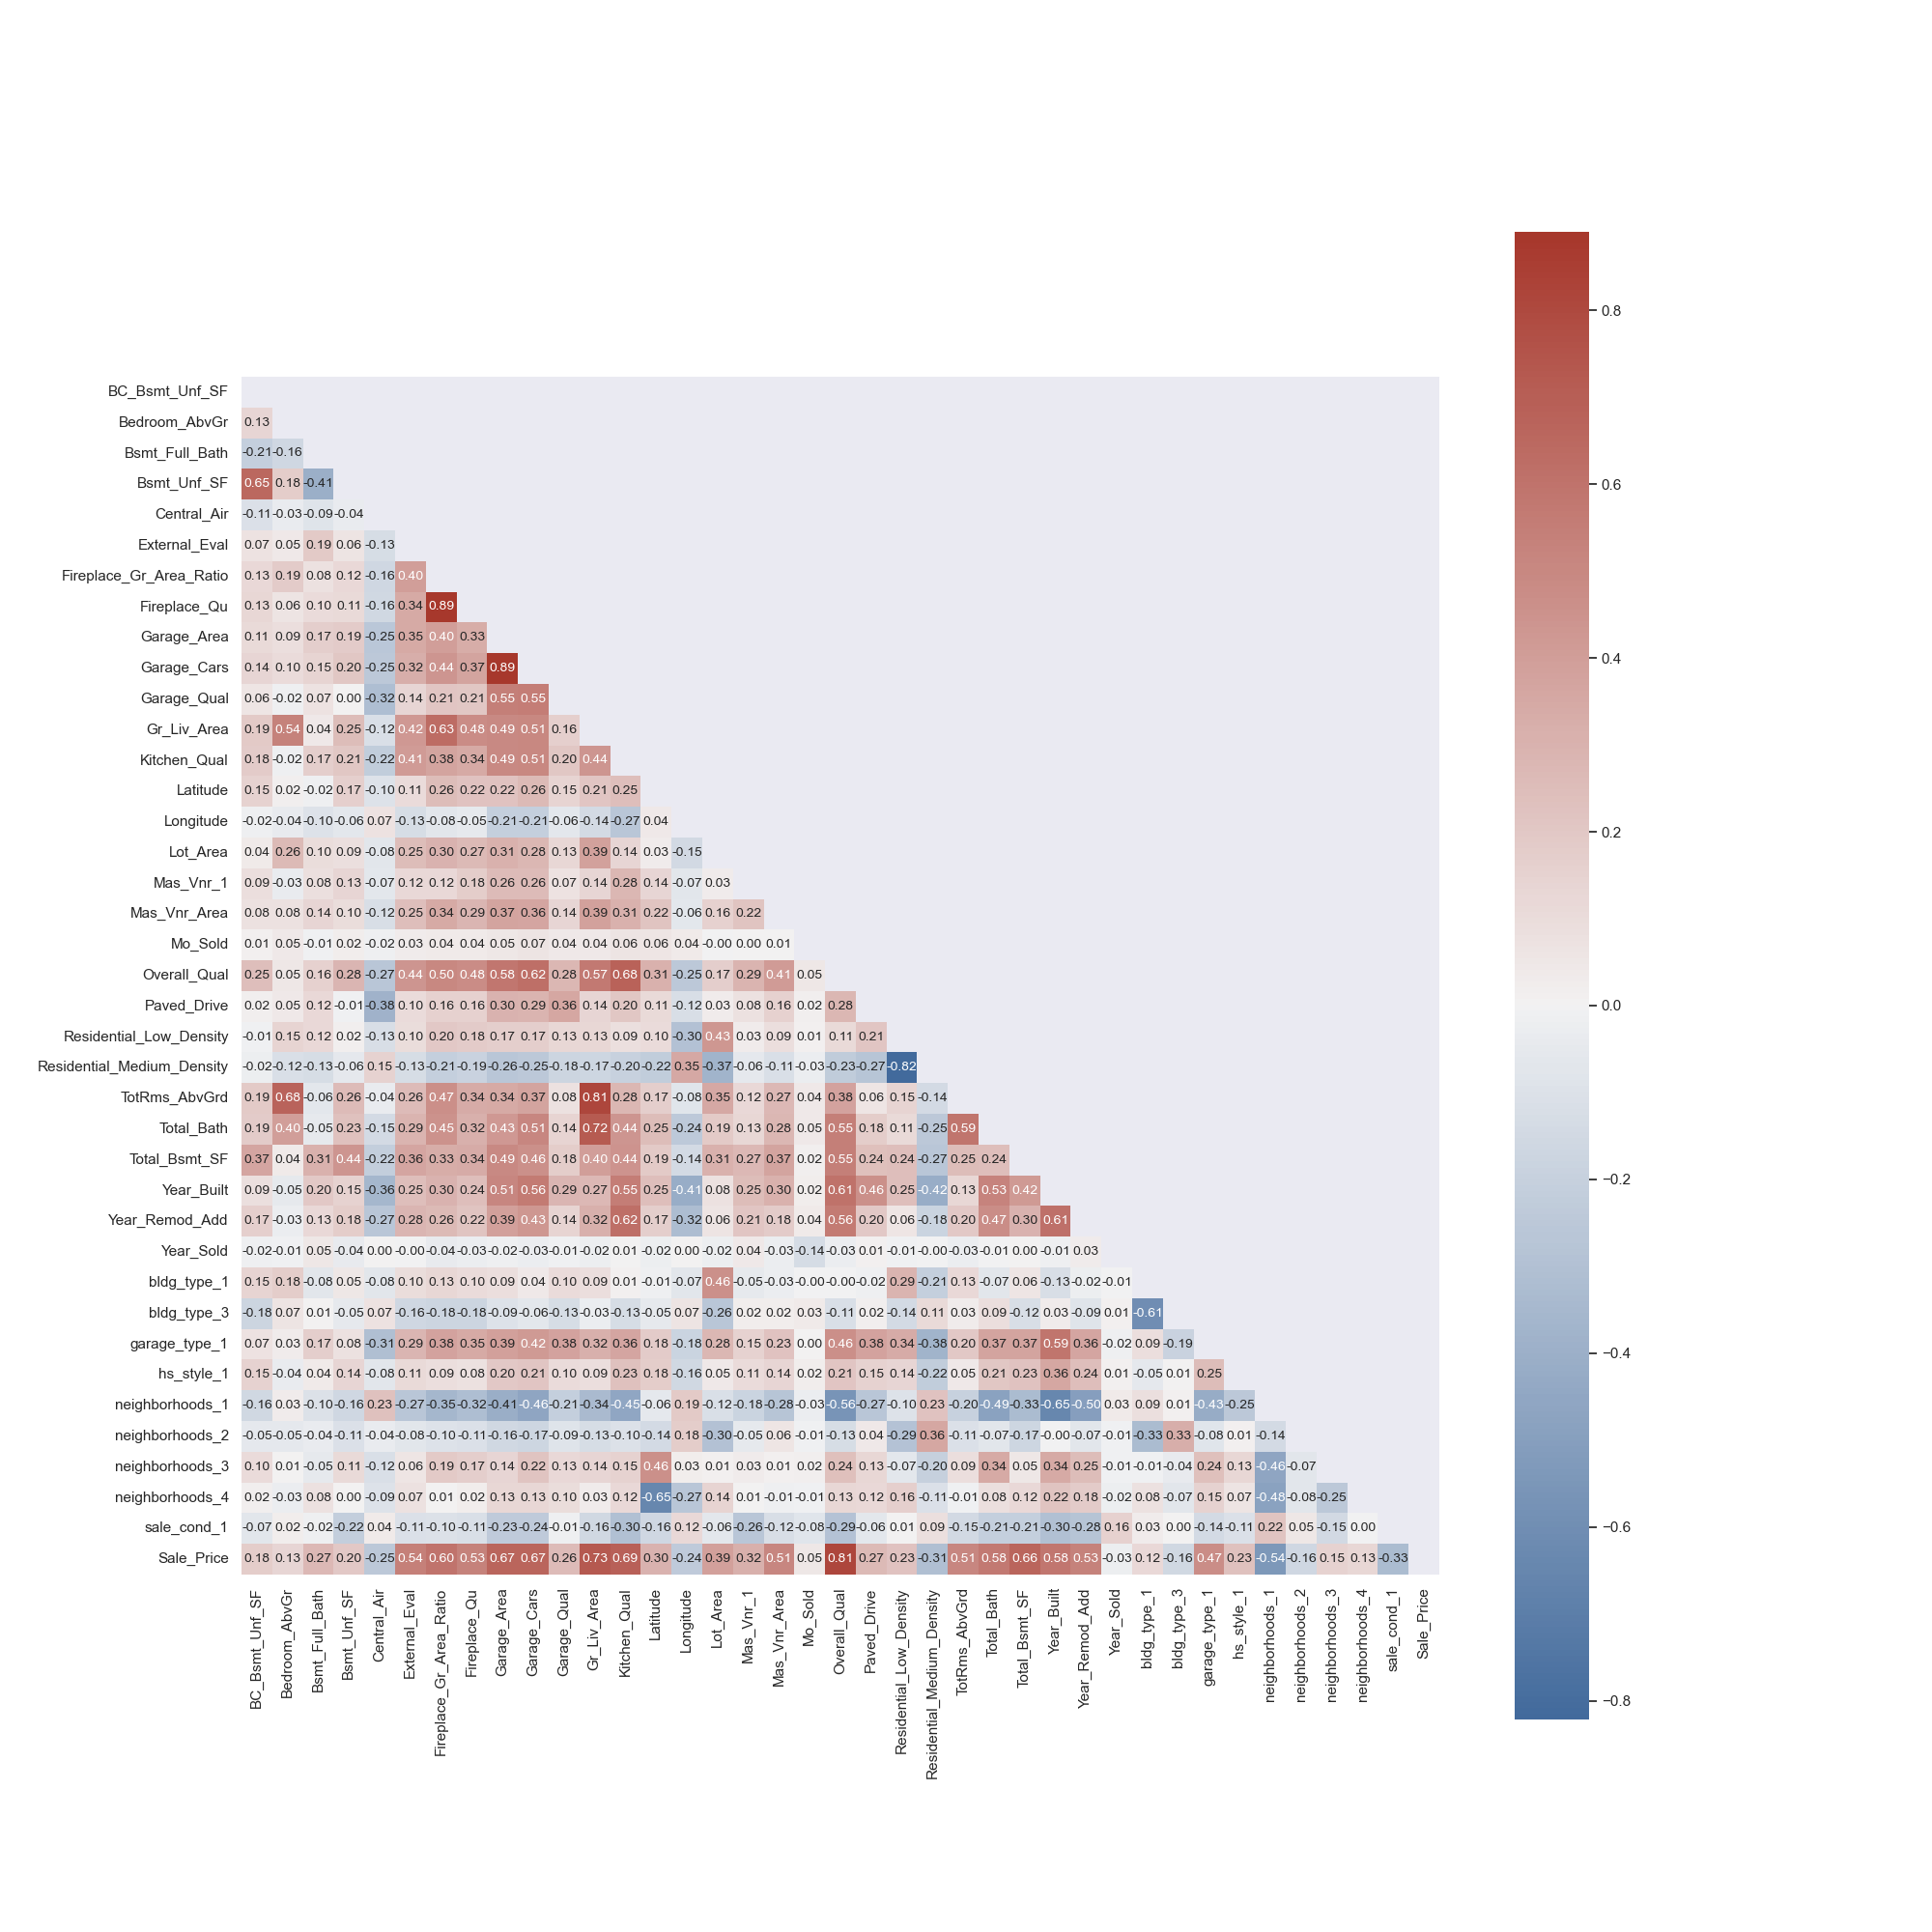

BC_Bsmt_Unf_SF  Bedroom_AbvGr  Bsmt_Full_Bath  \
BC_Bsmt_Unf_SF                    1.000000       0.134923       -0.209821   
Bedroom_AbvGr                     0.134923       1.000000       -0.159611   
Bsmt_Full_Bath                   -0.209821      -0.159611        1.000000   
Bsmt_Unf_SF                       0.654828       0.177789       -0.405607   
Central_Air                      -0.108313      -0.034916       -0.088172   
External_Eval                     0.069221       0.046173        0.192532   
Fireplace_Gr_Area_Ratio           0.127849       0.185904        0.080138   
Fireplace_Qu                      0.131604       0.063816        0.102543   
Garage_Area                       0.113086       0.088519        0.171390   
Garage_Cars                       0.136743       0.103566        0.147713   
Garage_Qual                       0.060592      -0.016694        0.071232   
Gr_Liv_Area                       0.193260       0.535752        0.041875   
Kitchen_Qual                      0.183995      -0.016033        0.168258   
Latitude                          0.149821       0.015748       -0.017084   
Longitude                        -0.017145      -0.039511       -0.098292   
Lot_Area                          0.039307       0.262098        0.095866   
Mas_Vnr_1                         0.089567      -0.033991        0.082185   
Mas_Vnr_Area                      0.079243       0.078224        0.136416   
Mo_Sold                           0.013989       0.045634       -0.008337   
Overall_Qual                      0.247288       0.051096        0.157665   
Paved_Drive                       0.015885       0.046632        0.120610   
Residential_Low_Density          -0.009592       0.147850        0.118009   
Residential_Medium_Density       -0.019552      -0.116620       -0.129047   
TotRms_AbvGrd                     0.189868       0.675896       -0.061089   
Total_Bath                        0.187139       0.398134       -0.048342   
Total_Bsmt_SF                     0.365913       0.035292        0.308319   
Year_Built                        0.086133      -0.052206        0.196785   
Year_Remod_Add                    0.167207      -0.028781        0.126091   
Year_Sold                        -0.017541      -0.007816        0.053937   
bldg_type_1                       0.145066       0.177683       -0.078911   
bldg_type_3                      -0.175838       0.066291        0.005859   
garage_type_1                     0.072912       0.030365        0.168383   
hs_style_1                        0.149648      -0.039124        0.036237   
neighborhoods_1                  -0.157497       0.034117       -0.101925   
neighborhoods_2                  -0.053088      -0.054505       -0.037325   
neighborhoods_3                   0.103629       0.006217       -0.049978   
neighborhoods_4                   0.018686      -0.031099        0.075200   
sale_cond_1                      -0.073918       0.022930       -0.016740   
Sale_Price                        0.178355       0.134824        0.273858   

                            Bsmt_Unf_SF  Central_Air  External_Eval  \
BC_Bsmt_Unf_SF                 0.654828    -0.108313       0.069221   
Bedroom_AbvGr                  0.177789    -0.034916       0.046173   
Bsmt_Full_Bath                -0.405607    -0.088172       0.192532   
Bsmt_Unf_SF                    1.000000    -0.035141       0.063412   
Central_Air                   -0.035141     1.000000      -0.126488   
External_Eval                  0.063412    -0.126488       1.000000   
Fireplace_Gr_Area_Ratio        0.121253    -0.161240       0.396041   
Fireplace_Qu                   0.111745    -0.158400       0.344991   
Garage_Area                    0.185510    -0.254607       0.347730   
Garage_Cars                    0.201965    -0.252972       0.323742   
Garage_Qual                    0.002943    -0.315217       0.136877   
Gr_Liv_Area                    0.248967    -0.117974       0.423898   
Kitchen_Qual            

In [26]:
display_corr_matrix(sort_alphabetically(df[subset_1], 'Sale_Price'), label='Sale_Price')

<IPython.core.display.Javascript object>


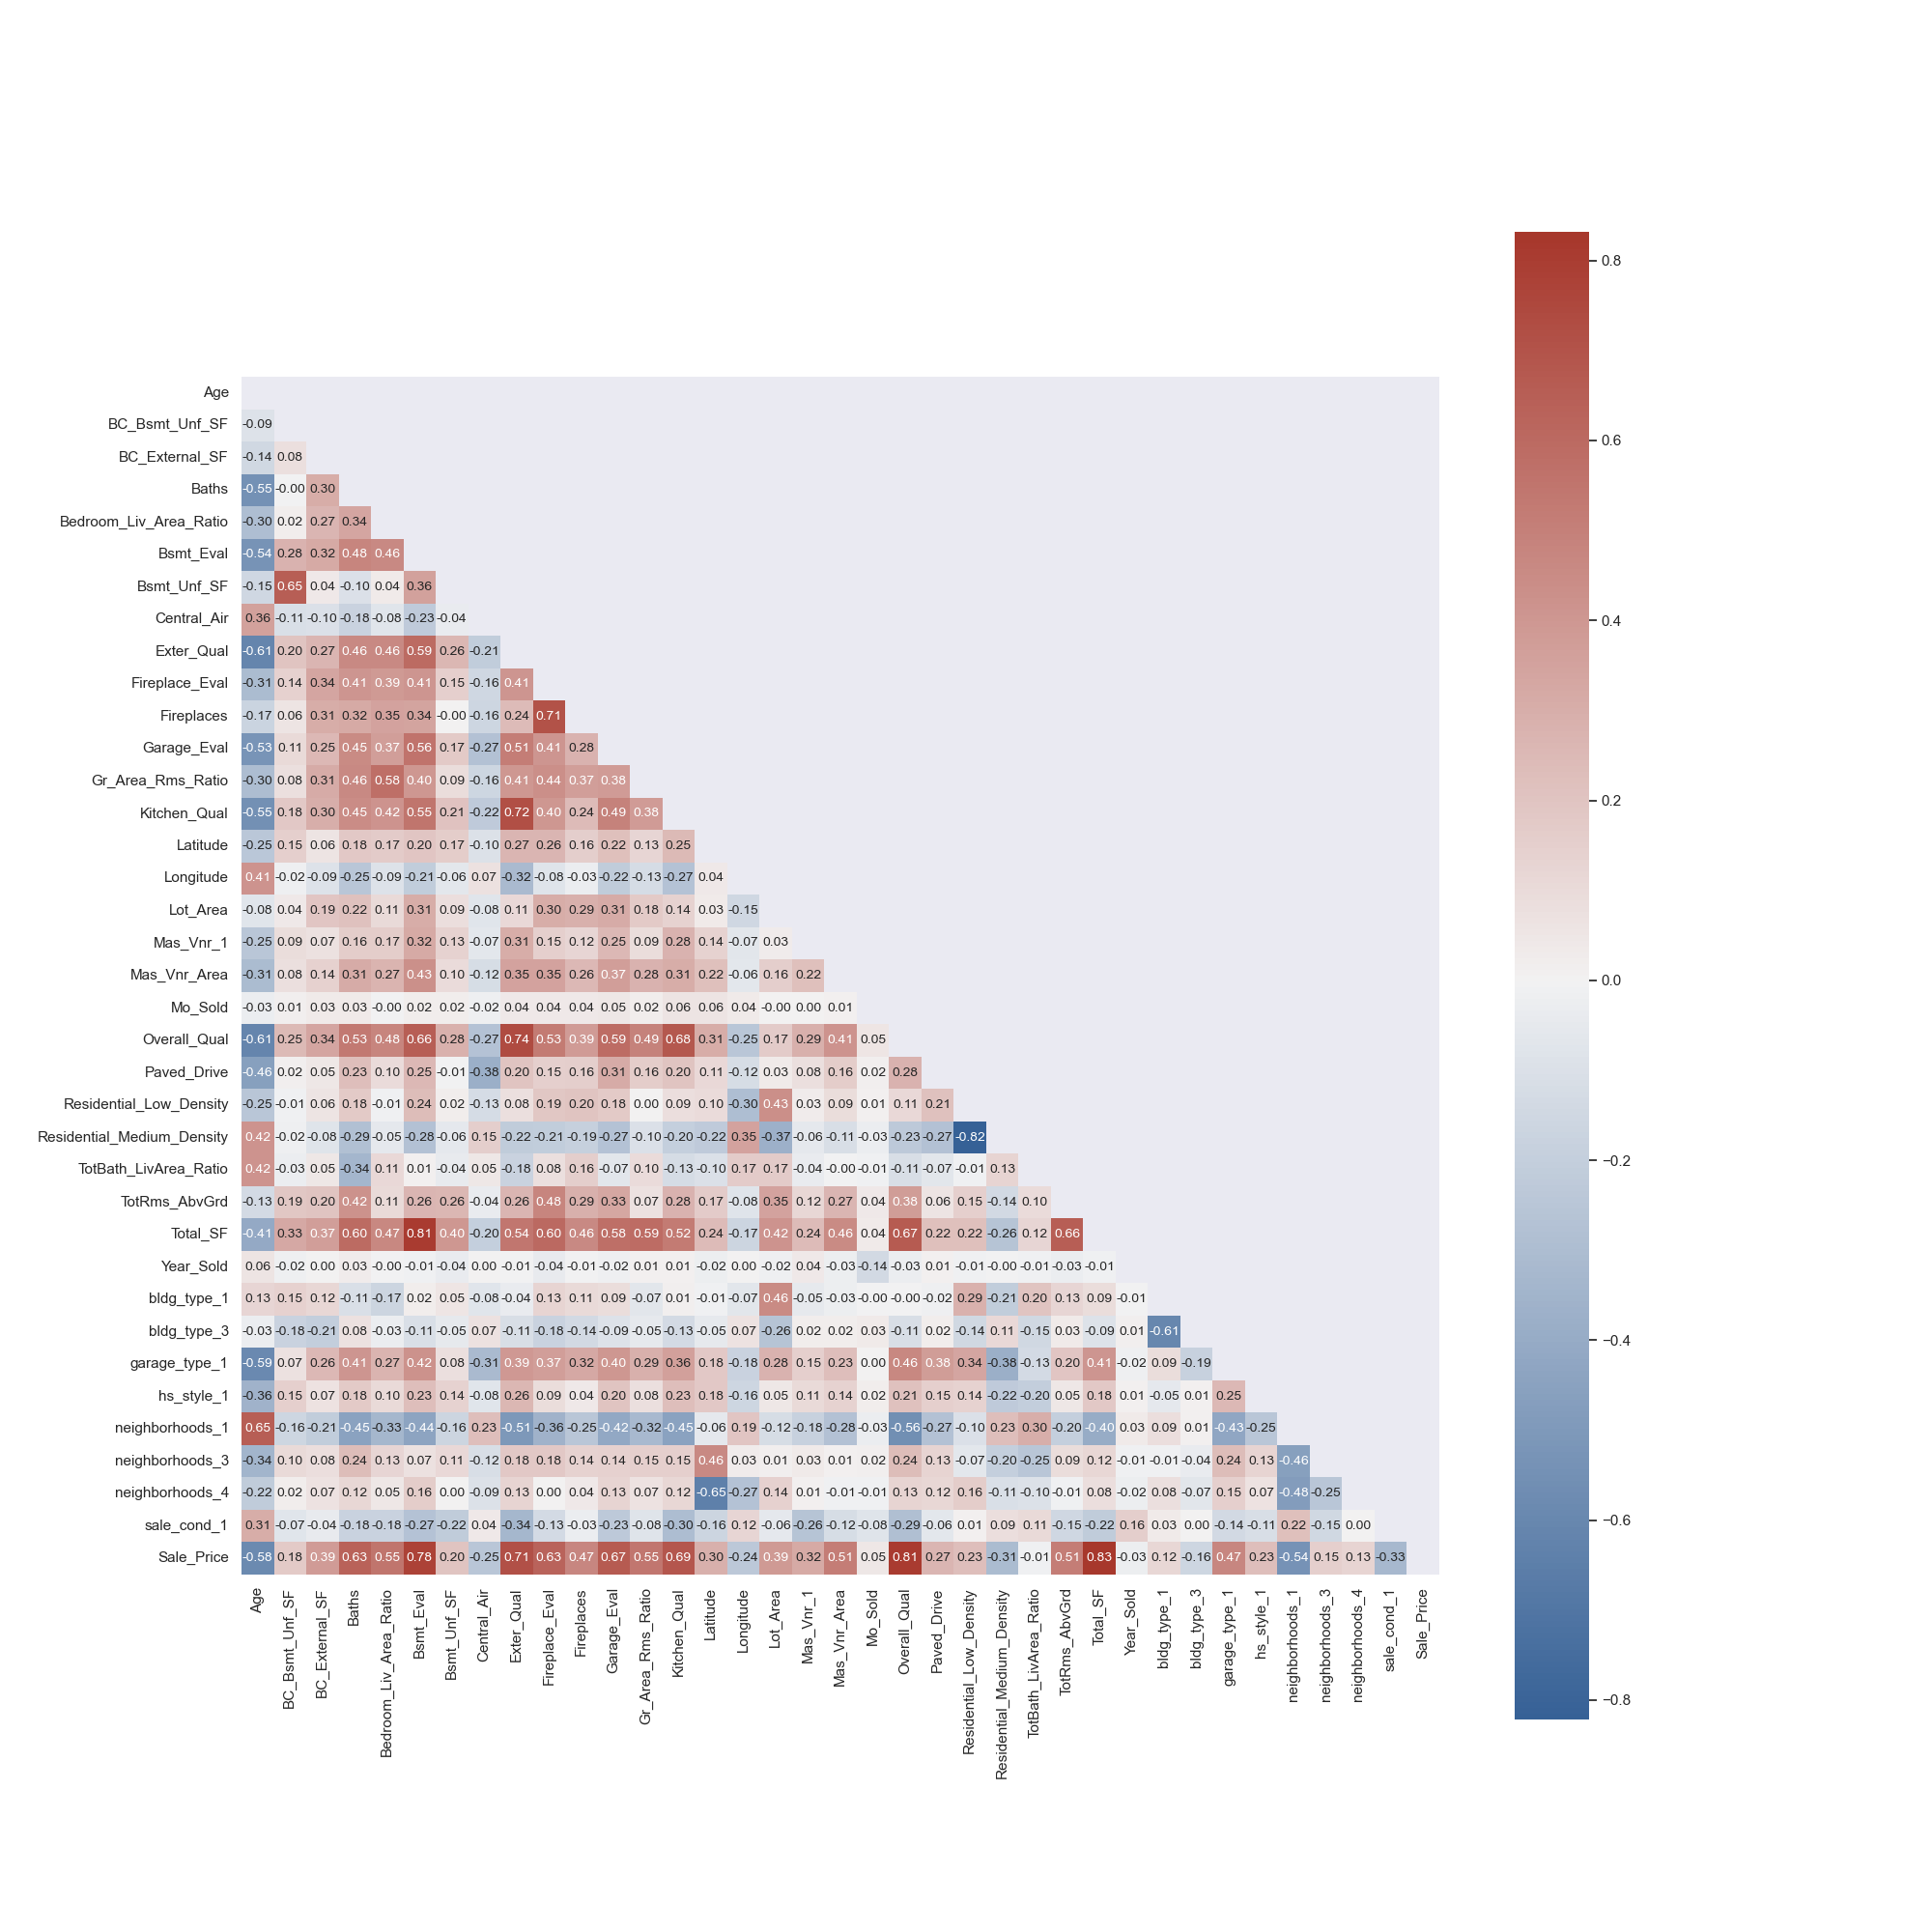

Age  BC_Bsmt_Unf_SF  BC_External_SF  \
Age                         1.000000       -0.086771       -0.144600   
BC_Bsmt_Unf_SF             -0.086771        1.000000        0.079418   
BC_External_SF             -0.144600        0.079418        1.000000   
Baths                      -0.545726       -0.002123        0.302741   
Bedroom_Liv_Area_Ratio     -0.297370        0.024367        0.268060   
Bsmt_Eval                  -0.536884        0.278250        0.315711   
Bsmt_Unf_SF                -0.153225        0.654828        0.041464   
Central_Air                 0.359021       -0.108313       -0.099373   
Exter_Qual                 -0.611551        0.202411        0.268662   
Fireplace_Eval             -0.307112        0.142910        0.337574   
Fireplaces                 -0.170278        0.058867        0.308420   
Garage_Eval                -0.527247        0.107528        0.252514   
Gr_Area_Rms_Ratio          -0.302678        0.079092        0.314691   
Kitchen_Qual               -0.551894        0.183995        0.297855   
Latitude                   -0.246640        0.149821        0.060887   
Longitude                   0.414292       -0.017145       -0.088093   
Lot_Area                   -0.076226        0.039307        0.194382   
Mas_Vnr_1                  -0.247407        0.089567        0.069851   
Mas_Vnr_Area               -0.305262        0.079243        0.142817   
Mo_Sold                    -0.029778        0.013989        0.032020   
Overall_Qual               -0.608950        0.247288        0.338004   
Paved_Drive                -0.460238        0.015885        0.049177   
Residential_Low_Density    -0.247810       -0.009592        0.061182   
Residential_Medium_Density  0.416150       -0.019552       -0.083773   
TotBath_LivArea_Ratio       0.418181       -0.027623        0.045319   
TotRms_AbvGrd              -0.132954        0.189868        0.199495   
Total_SF                   -0.408380        0.327731        0.367331   
Year_Sold                   0.058521       -0.017541        0.000509   
bldg_type_1                 0.125249        0.145066        0.115915   
bldg_type_3                -0.031538       -0.175838       -0.207157   
garage_type_1              -0.589224        0.072912        0.255324   
hs_style_1                 -0.357392        0.149648        0.065961   
neighborhoods_1             0.652524       -0.157497       -0.209164   
neighborhoods_3            -0.344409        0.103629        0.083835   
neighborhoods_4            -0.218910        0.018686        0.066174   
sale_cond_1                 0.308439       -0.073918       -0.044475   
Sale_Price                 -0.583683        0.178355        0.385545   

                               Baths  Bedroom_Liv_Area_Ratio  Bsmt_Eval  \
Age                        -0.545726               -0.297370  -0.536884   
BC_Bsmt_Unf_SF             -0.002123                0.024367   0.278250   
BC_External_SF              0.302741                0.268060   0.315711   
Baths                       1.000000                0.335688   0.478609   
Bedroom_Liv_Area_Ratio      0.335688                1.000000   0.463226   
Bsmt_Eval                   0.478609                0.463226   1.000000   
Bsmt_Unf_SF                -0.102012                0.035949   0.360213   
Central_Air                -0.180460               -0.078621  -0.226752   
Exter_Qual                  0.463121                0.459954   0.594268   
Fireplace_Eval              0.410843                0.392150   0.409352   
Fireplaces                  0.316670                0.351968   0.342506   
Garage_Eval                 0.451585                0.369629   0.555056   
Gr_Area_Rms_Ratio           0.462849                0.579080   0.400194   
Kitchen_Qual                0.450008                0.416178   0.548624   
Latitude                    0.182503                0.171279   0.196751   
Longitude                  -0.247660               -0.091068  -0.208453   
Lot_Area             

In [27]:
display_corr_matrix(sort_alphabetically(df[subset_2], 'Sale_Price'), label='Sale_Price')

<IPython.core.display.Javascript object>


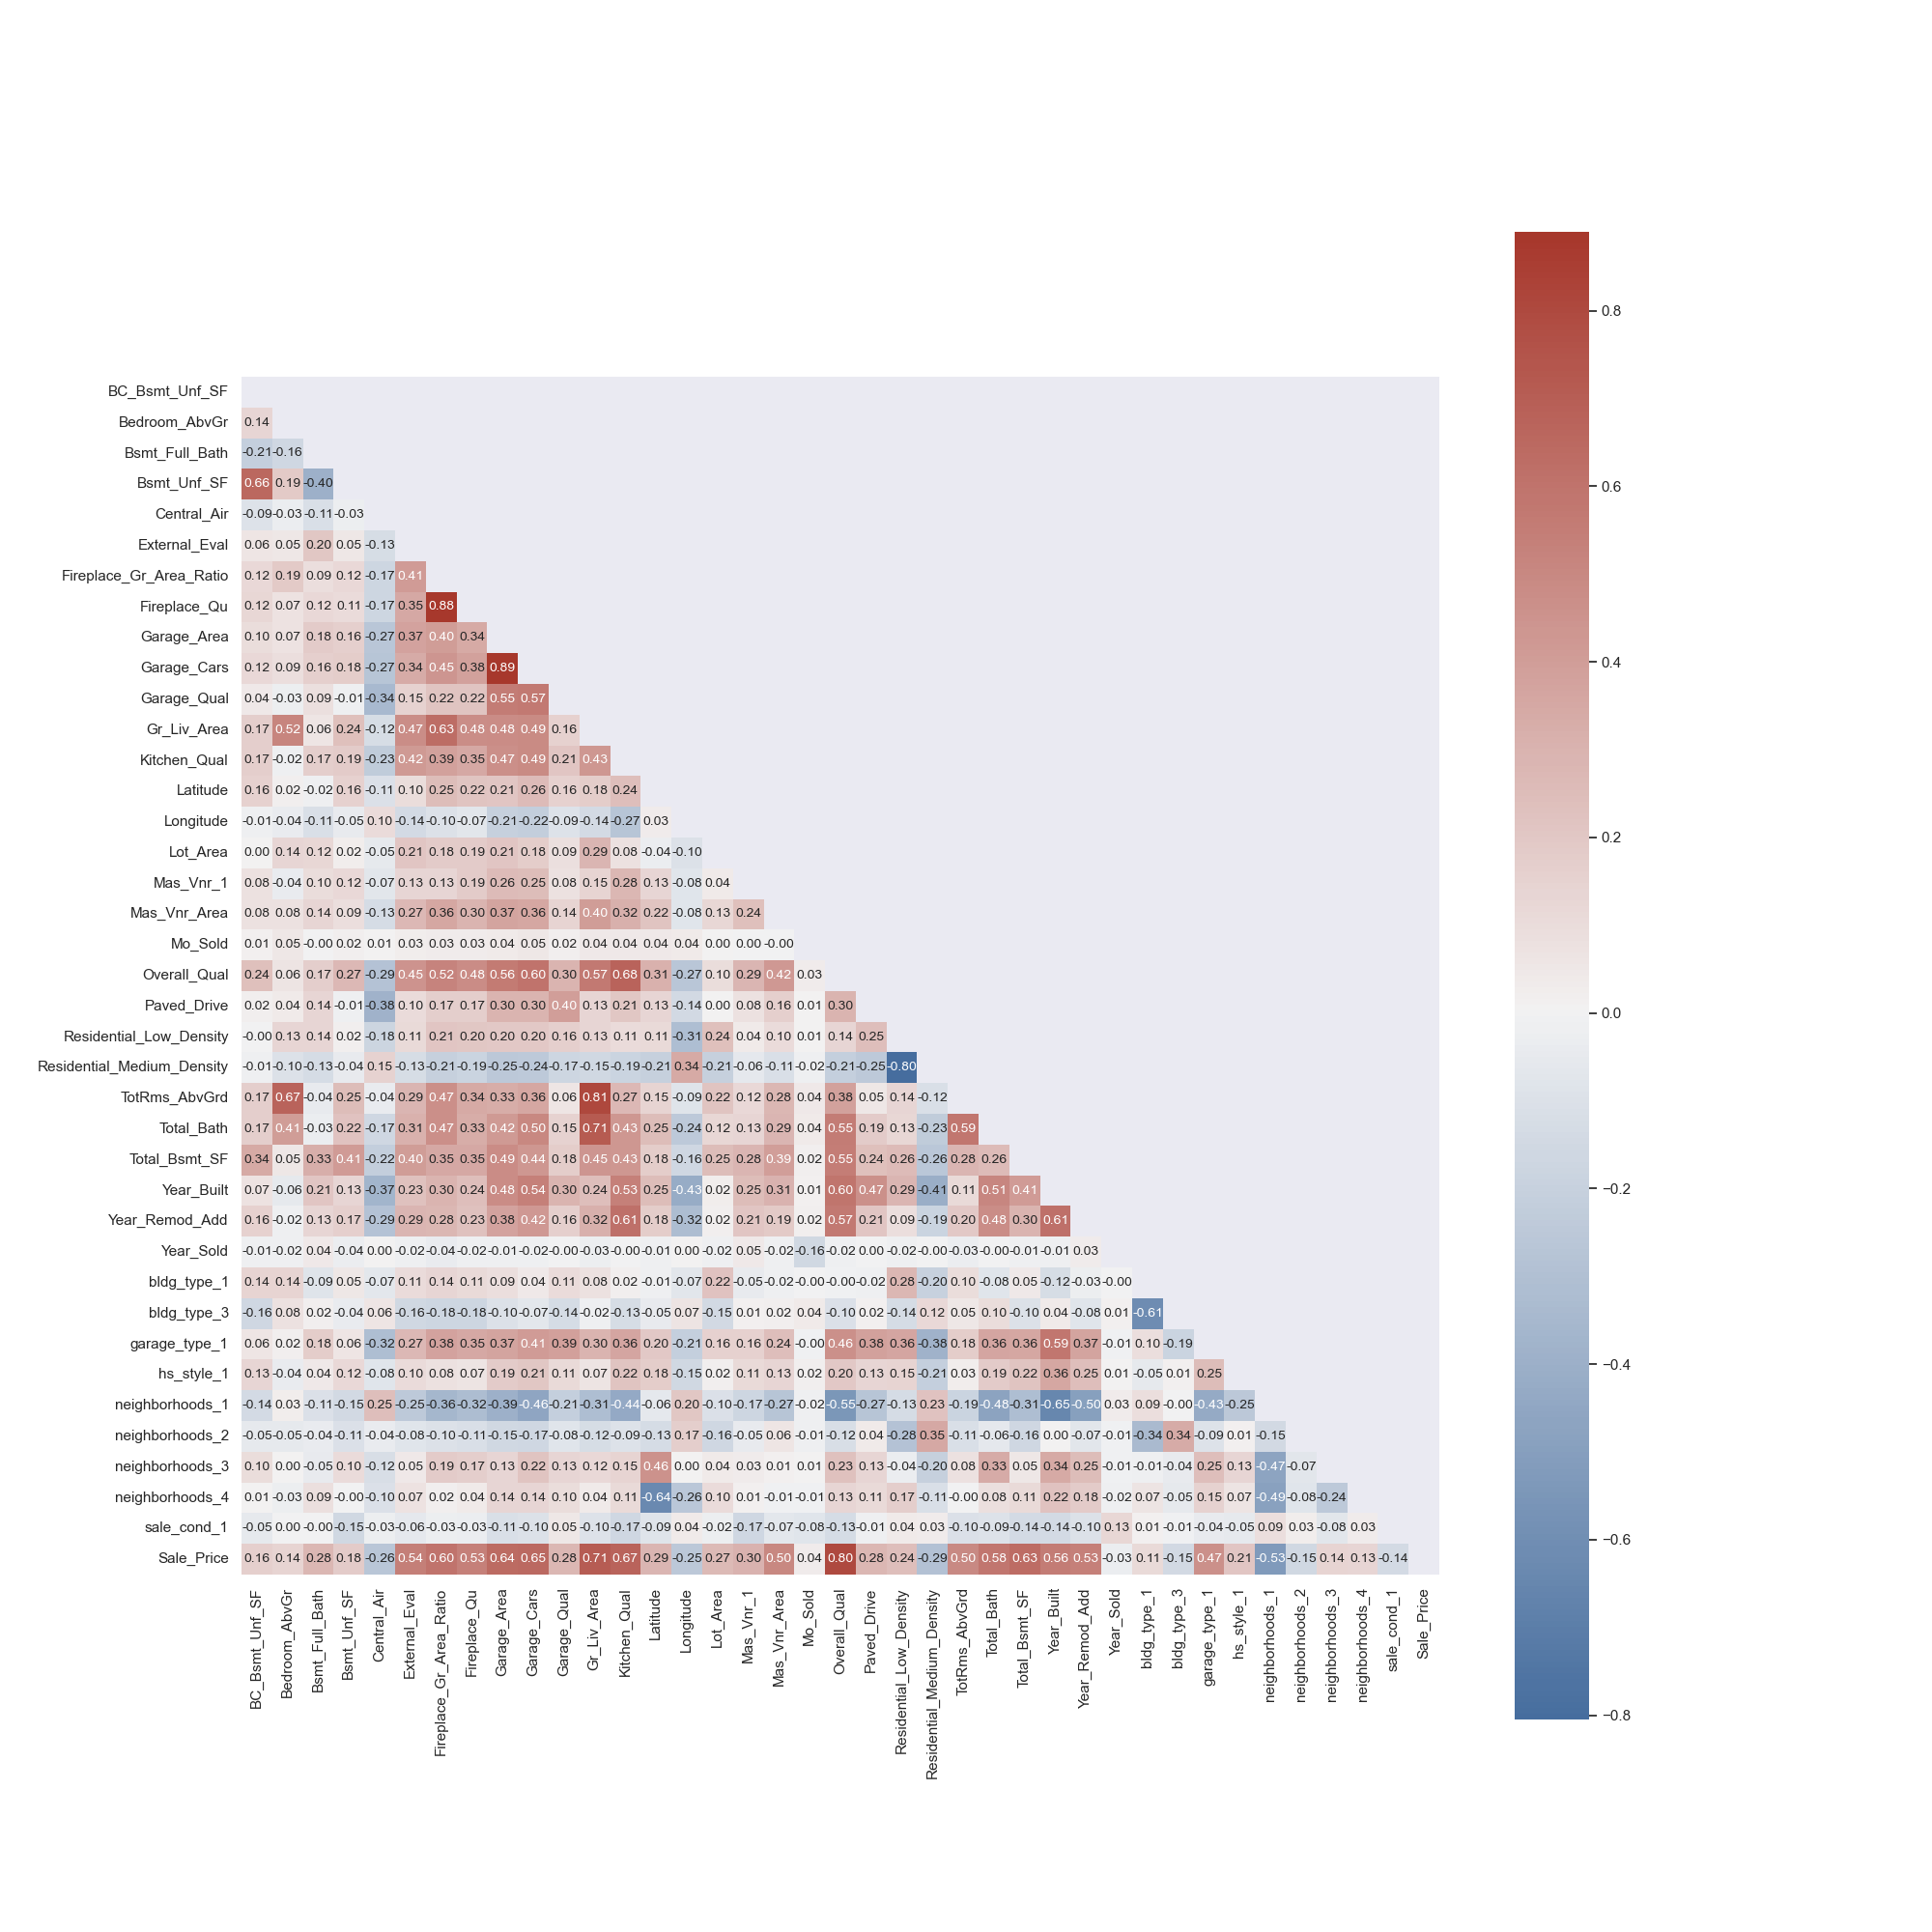

BC_Bsmt_Unf_SF  Bedroom_AbvGr  Bsmt_Full_Bath  \
BC_Bsmt_Unf_SF                    1.000000       0.141282       -0.209373   
Bedroom_AbvGr                     0.141282       1.000000       -0.161084   
Bsmt_Full_Bath                   -0.209373      -0.161084        1.000000   
Bsmt_Unf_SF                       0.656611       0.188508       -0.398629   
Central_Air                      -0.094314      -0.032083       -0.113226   
External_Eval                     0.058795       0.050366        0.203460   
Fireplace_Gr_Area_Ratio           0.121848       0.188608        0.091116   
Fireplace_Qu                      0.122529       0.070137        0.119347   
Garage_Area                       0.097501       0.073417        0.184903   
Garage_Cars                       0.119759       0.091135        0.162644   
Garage_Qual                       0.042779      -0.029824        0.088716   
Gr_Liv_Area                       0.173359       0.516808        0.057367   
Kitchen_Qual                      0.169108      -0.022821        0.173919   
Latitude                          0.155091       0.017599       -0.015954   
Longitude                        -0.013459      -0.038976       -0.114530   
Lot_Area                          0.004231       0.136569        0.124208   
Mas_Vnr_1                         0.078245      -0.038026        0.099529   
Mas_Vnr_Area                      0.078487       0.080590        0.139684   
Mo_Sold                           0.010934       0.053677       -0.003322   
Overall_Qual                      0.240588       0.063291        0.168373   
Paved_Drive                       0.016362       0.036148        0.135779   
Residential_Low_Density          -0.003148       0.134725        0.136010   
Residential_Medium_Density       -0.013896      -0.099208       -0.132350   
TotRms_AbvGrd                     0.173828       0.672647       -0.043642   
Total_Bath                        0.172730       0.405780       -0.033624   
Total_Bsmt_SF                     0.343994       0.052721        0.326861   
Year_Built                        0.072667      -0.055093        0.212119   
Year_Remod_Add                    0.158592      -0.021536        0.134590   
Year_Sold                        -0.010492      -0.018008        0.044805   
bldg_type_1                       0.143899       0.143481       -0.086659   
bldg_type_3                      -0.162531       0.079306        0.018858   
garage_type_1                     0.057262       0.018036        0.175432   
hs_style_1                        0.134920      -0.042486        0.043031   
neighborhoods_1                  -0.136714       0.026957       -0.109659   
neighborhoods_2                  -0.053477      -0.053070       -0.042999   
neighborhoods_3                   0.096655       0.003486       -0.045609   
neighborhoods_4                   0.005947      -0.028476        0.085561   
sale_cond_1                      -0.054631       0.000709       -0.001950   
Sale_Price                        0.162569       0.143913        0.275823   

                            Bsmt_Unf_SF  Central_Air  External_Eval  \
BC_Bsmt_Unf_SF                 0.656611    -0.094314       0.058795   
Bedroom_AbvGr                  0.188508    -0.032083       0.050366   
Bsmt_Full_Bath                -0.398629    -0.113226       0.203460   
Bsmt_Unf_SF                    1.000000    -0.026795       0.054194   
Central_Air                   -0.026795     1.000000      -0.126144   
External_Eval                  0.054194    -0.126144       1.000000   
Fireplace_Gr_Area_Ratio        0.120690    -0.171926       0.411627   
Fireplace_Qu                   0.108233    -0.172574       0.347101   
Garage_Area                    0.164837    -0.268515       0.373576   
Garage_Cars                    0.180080    -0.274966       0.338247   
Garage_Qual                   -0.010800    -0.342492       0.152601   
Gr_Liv_Area                    0.235870    -0.123217       0.473200   
Kitchen_Qual            

In [28]:
display_corr_matrix(sort_alphabetically(df_orig[subset_1], 'Sale_Price'), label='Sale_Price')

<IPython.core.display.Javascript object>


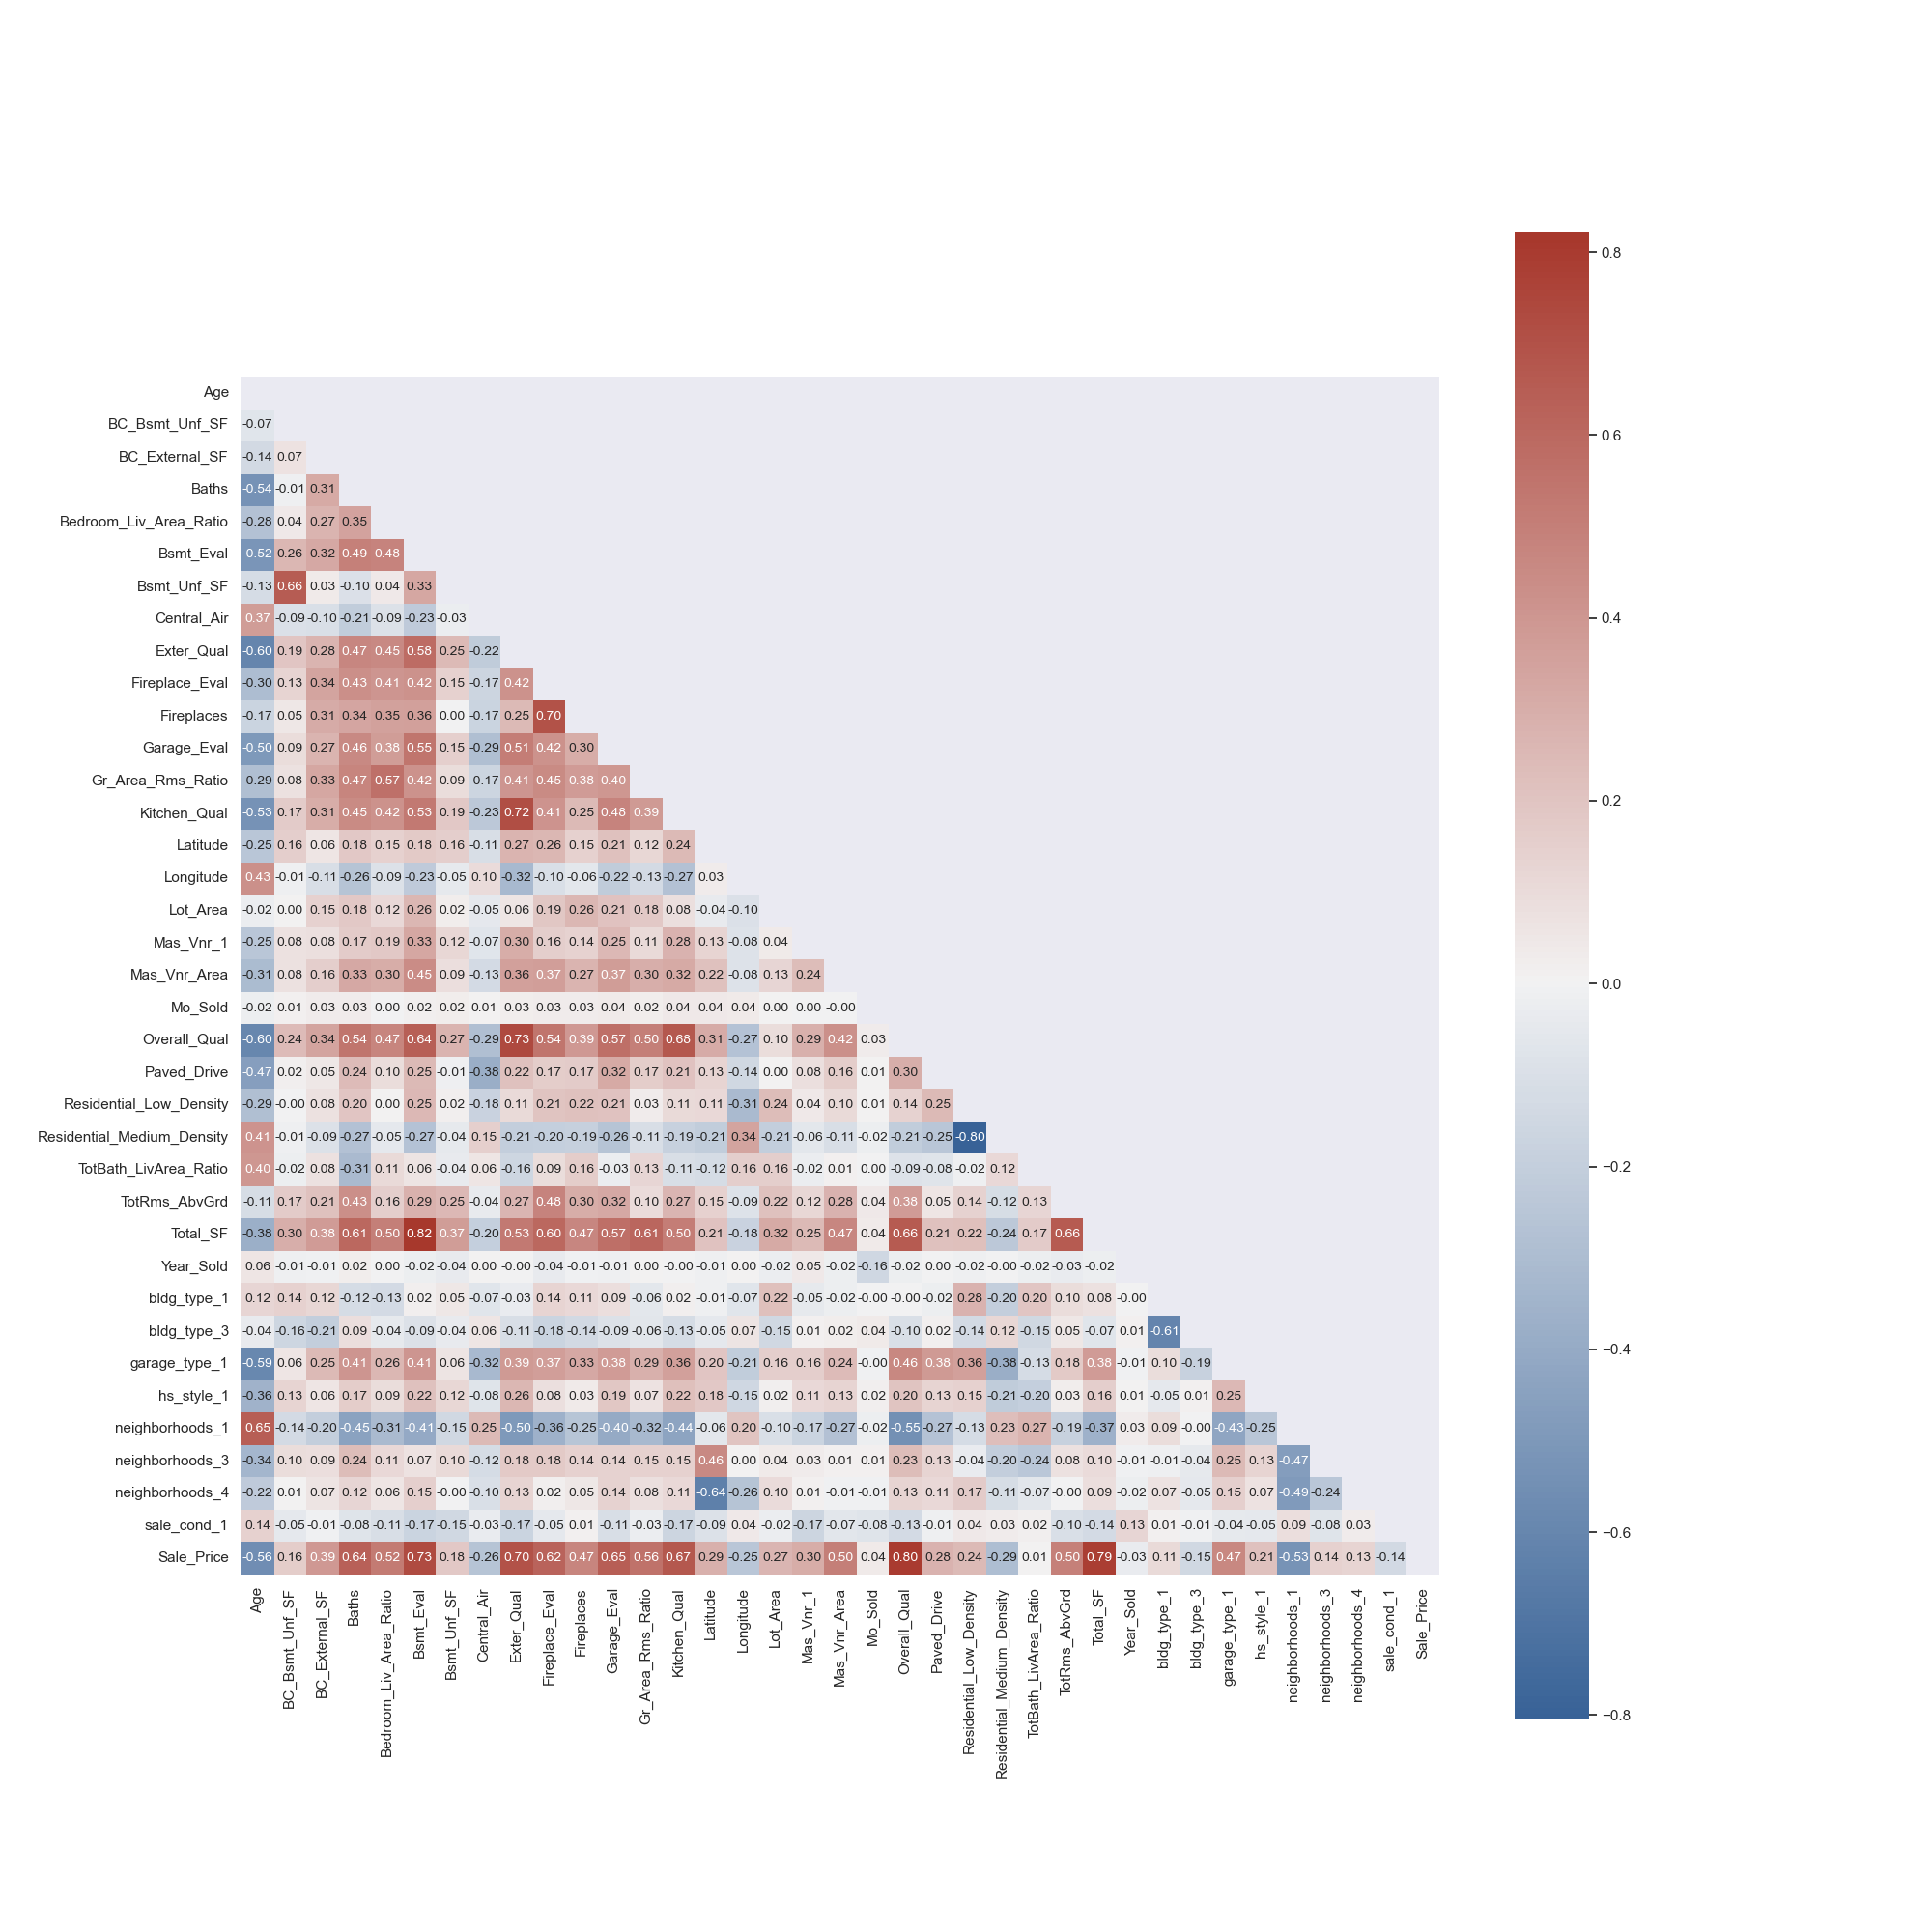

Age  BC_Bsmt_Unf_SF  BC_External_SF  \
Age                         1.000000       -0.073015       -0.140445   
BC_Bsmt_Unf_SF             -0.073015        1.000000        0.068291   
BC_External_SF             -0.140445        0.068291        1.000000   
Baths                      -0.536645       -0.010750        0.313780   
Bedroom_Liv_Area_Ratio     -0.276171        0.040670        0.274534   
Bsmt_Eval                  -0.517500        0.257757        0.322493   
Bsmt_Unf_SF                -0.130710        0.656611        0.034239   
Central_Air                 0.371259       -0.094314       -0.101956   
Exter_Qual                 -0.604606        0.194429        0.275057   
Fireplace_Eval             -0.302604        0.134858        0.343987   
Fireplaces                 -0.170756        0.052837        0.312914   
Garage_Eval                -0.496906        0.093078        0.274438   
Gr_Area_Rms_Ratio          -0.287596        0.078277        0.328714   
Kitchen_Qual               -0.533009        0.169108        0.306691   
Latitude                   -0.251522        0.155091        0.059253   
Longitude                   0.425076       -0.013459       -0.108686   
Lot_Area                   -0.024226        0.004231        0.148345   
Mas_Vnr_1                  -0.247087        0.078245        0.082099   
Mas_Vnr_Area               -0.307071        0.078487        0.156233   
Mo_Sold                    -0.021326        0.010934        0.027818   
Overall_Qual               -0.597020        0.240588        0.340043   
Paved_Drive                -0.465444        0.016362        0.048614   
Residential_Low_Density    -0.288475       -0.003148        0.076343   
Residential_Medium_Density  0.411115       -0.013896       -0.090704   
TotBath_LivArea_Ratio       0.397926       -0.021107        0.077095   
TotRms_AbvGrd              -0.113079        0.173828        0.214161   
Total_SF                   -0.375447        0.297205        0.379025   
Year_Sold                   0.056653       -0.010492       -0.008568   
bldg_type_1                 0.124583        0.143899        0.122145   
bldg_type_3                -0.036578       -0.162531       -0.206800   
garage_type_1              -0.591290        0.057262        0.247151   
hs_style_1                 -0.357988        0.134920        0.058236   
neighborhoods_1             0.646797       -0.136714       -0.202430   
neighborhoods_3            -0.340742        0.096655        0.085350   
neighborhoods_4            -0.222511        0.005947        0.065263   
sale_cond_1                 0.142508       -0.054631       -0.010134   
Sale_Price                 -0.558910        0.162569        0.390039   

                               Baths  Bedroom_Liv_Area_Ratio  Bsmt_Eval  \
Age                        -0.536645               -0.276171  -0.517500   
BC_Bsmt_Unf_SF             -0.010750                0.040670   0.257757   
BC_External_SF              0.313780                0.274534   0.322493   
Baths                       1.000000                0.348439   0.491904   
Bedroom_Liv_Area_Ratio      0.348439                1.000000   0.482323   
Bsmt_Eval                   0.491904                0.482323   1.000000   
Bsmt_Unf_SF                -0.097314                0.043578   0.331419   
Central_Air                -0.213567               -0.087163  -0.226163   
Exter_Qual                  0.471762                0.454429   0.581395   
Fireplace_Eval              0.429533                0.407410   0.417893   
Fireplaces                  0.338265                0.353886   0.360120   
Garage_Eval                 0.457288                0.377162   0.545149   
Gr_Area_Rms_Ratio           0.474594                0.567069   0.420764   
Kitchen_Qual                0.450502                0.417113   0.529156   
Latitude                    0.182846                0.148281   0.180259   
Longitude                  -0.260048               -0.090487  -0.226383   
Lot_Area             

In [29]:
display_corr_matrix(sort_alphabetically(df_orig[subset_2], 'Sale_Price'), label='Sale_Price')

The results obtained are very satisfying!

---

### Save the dataset

I decided to keep only three datasets to test my hypothesis.

In [30]:
df[subset_1].to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_21.csv"))
df[subset_2].to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_22.csv"))

df_orig[subset_2].to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_22_orig.csv"))